### Imports:

In [54]:
# !pip install hdbscan
# !pip install umap-learn
# !pip install mplcursors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import BertTokenizer, BertModel

from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN

from sklearn import metrics
from tqdm.notebook import trange

import umap
import mplcursors

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os

#### Loading Data:

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Creating Embeddings on Utterance Level using BERT, BERT Banking and TF-IDF:

### Create BERT Uncased Embeddings on Utterance Level:

In [29]:
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERT_model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [30]:
def get_bert_embeddings(sentence):
    inputs = BERT_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = BERT_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_bert_embeddings)
test

,text,category,BERT77_embeddings,topic,BERT_embeddings
0,How do I locate my card?,card_arrival,"[0.4286521, -0.4346951, 0.30529416, 0.23473713...",55,"[0.1194671, 0.04625155, 0.07216135, -0.0717435..."
1,"I still have not received my new card, I order...",card_arrival,"[0.16829135, 0.09822839, 1.3819339, -0.1845504...",35,"[0.14556462, -0.17301661, 0.39641762, 0.206252..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[0.12018988, -0.12310968, 1.4518344, 0.2730050...",35,"[-0.050331775, -0.25570148, 0.44595438, -0.030..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.15183577, 0.08295745, 1.4436903, 0.0787068...",14,"[-0.044740755, -0.3670078, 0.41925094, 0.03467..."
4,My card has not arrived yet.,card_arrival,"[0.24080832, 0.40944976, 1.2567022, -0.2404647...",35,"[0.30289176, -0.22428077, 0.10192676, -0.20357..."
...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.2742988, -0.8255165, 0.2538386, 0.8105235, ...",21,"[0.49874604, -0.046891544, 0.43037662, -0.3773..."
3076,How many countries do you support?,country_support,"[0.33265126, -0.54593444, 0.06223802, 0.783922...",21,"[0.4169193, -0.19576645, 0.102779716, -0.10128..."
3077,What countries do you do business in?,country_support,"[0.42628327, -0.46747446, 0.20949447, 0.791910...",21,"[0.43335462, -0.14970124, -0.07299803, -0.2744..."
3078,What are the countries you operate in.,country_support,"[0.41574997, -0.5905342, 0.29422683, 0.8811766...",21,"[0.2613634, -0.20304796, -0.1526416, -0.174456..."


In [31]:
# The number of elements in each embedding
len(test['BERT_embeddings'].iloc[0])

768

### Create TF-IDF Embeddings on Utterance Level:

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=15, max_df=0.85, ngram_range=(1, 2))

In [ ]:
X_tfidf = tfidf_vectorizer.fit_transform(test['text'])
test['TF_IDF_embeddings'] = list(X_tfidf.toarray())

### Create BERT Banking Embeddings on Utterance Level:

In [4]:
BERT_bank_tokenizer = BertTokenizer.from_pretrained('philschmid/BERT-Banking77')
BERT_bank_model = BertModel.from_pretrained('philschmid/BERT-Banking77')

In [5]:
def get_bert_banking_embeddings(sentence):
    inputs = BERT_bank_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = BERT_bank_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT77_embeddings'] = test['text'].apply(get_bert_banking_embeddings)
test

,text,category,BERT77_embeddings
0,How do I locate my card?,card_arrival,"[0.4286521, -0.4346951, 0.30529416, 0.23473713..."
1,"I still have not received my new card, I order...",card_arrival,"[0.16829135, 0.09822839, 1.3819339, -0.1845504..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[0.12018988, -0.12310968, 1.4518344, 0.2730050..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.15183577, 0.08295745, 1.4436903, 0.0787068..."
4,My card has not arrived yet.,card_arrival,"[0.24080832, 0.40944976, 1.2567022, -0.2404647..."
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.2742988, -0.8255165, 0.2538386, 0.8105235, ..."
3076,How many countries do you support?,country_support,"[0.33265126, -0.54593444, 0.06223802, 0.783922..."
3077,What countries do you do business in?,country_support,"[0.42628327, -0.46747446, 0.20949447, 0.791910..."
3078,What are the countries you operate in.,country_support,"[0.41574997, -0.5905342, 0.29422683, 0.8811766..."


In [6]:
# The number of elements in each embedding
len(test['BERT77_embeddings'].iloc[0])

768

## Dimension Reduction (UMAP) and Clustering:

### Performing Grid Search to Identify the Best Parameters:

In [39]:
# import itertools

# # Run a grid search for BERT Banking by checking the silhouette score
# # Use the best parameters for both BERT Banking and BERT Uncased

# def perform_umap(embeddings, n_neighbors, n_components, metric):
#     """
#     Apply UMAP dimension reduction to the embeddings.
#     """
#     reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components,
#                         metric=metric, random_state=42)
#     return reducer.fit_transform(embeddings)

# def perform_hdbscan(umap_embeddings, min_cluster_size, min_samples, gen_min_span_tree, cluster_selection_method):
#     """
#     Apply HDBSCAN clustering to the dimension-reduced data.
#     """
#     clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
#                         gen_min_span_tree=gen_min_span_tree,
#                         cluster_selection_method=cluster_selection_method)
#     return clusterer.fit(umap_embeddings)

# def grid_search(df, umap_params, hdbscan_params):
#     """
#     Perform a grid search over the specified ranges of UMAP and HDBSCAN parameters.
#     """
#     results = []
#     embeddings = np.stack(df['BERT77_embeddings'].values)

#     for umap_param_set in itertools.product(*umap_params.values()):
#         umap_embeddings = perform_umap(embeddings, *umap_param_set)

#         for hdbscan_param_set in itertools.product(*hdbscan_params.values()):
#             clusterer = perform_hdbscan(umap_embeddings, *hdbscan_param_set)
#             labels = clusterer.labels_

#             # Calculate silhouette score only if more than one cluster is found
#             if len(set(labels)) - (1 if -1 in labels else 0) > 1:
#                 score = silhouette_score(umap_embeddings, labels)
#             else:
#                 score = -1

#             result = {**dict(zip(umap_params.keys(), umap_param_set)),
#                       **dict(zip(hdbscan_params.keys(), hdbscan_param_set)),
#                       "silhouette_score": score}
#             results.append(result)

#     return pd.DataFrame(results)

# # Define your UMAP and HDBSCAN parameter grids
# umap_params = {
#     "n_neighbors": range(15, 51, 10),  # Exploring from 15 to 50 in steps of 10
#     "n_components": range(2, 21, 6),  # Exploring from 2 to 20 in steps of 6
#     "metric": ["cosine"]
# }

# hdbscan_params = {
#     "min_cluster_size": range(15, 61, 15),  # Exploring from 15 to 60 in steps of 15
#     "min_samples": [None] + list(range(1, 31, 10)),  # None, then exploring from 1 to 30 in steps of 10
#     "gen_min_span_tree": [True, False],
#     "cluster_selection_method": ["eom", "leaf"]
# }

# # Save results into a dataframe
# results_df = grid_search(test, umap_params, hdbscan_params)

In [44]:
# results_df.sort_values(by="silhouette_score", ascending=False).head()

The best parameters of UMAP and HDBSCAN for BERT Banking after running a grid search with silhouette score are:

*   n_neighbors: 35
*   n_components: 2
*   metric: cosine
*   min_cluster_size: 15
*   min_samples: 21
*   gen_min_span_tree: True
*   cluster_selection_method: eom

With a silhouette score of 0.947

In [50]:
# import itertools

# # Run a grid search for BERT Banking by checking the the proportion of points with low membership probabilities
# # Use the best parameters for both BERT Banking and BERT Uncased

# def perform_umap(embeddings, n_neighbors, n_components, metric):
#     """
#     Apply UMAP dimension reduction to the embeddings.
#     """
#     reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components,
#                         metric=metric, random_state=42)
#     return reducer.fit_transform(embeddings)

# def perform_hdbscan(umap_embeddings, min_cluster_size, min_samples, gen_min_span_tree, cluster_selection_method):
#     """
#     Apply HDBSCAN clustering to the dimension-reduced data.
#     """
#     clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
#                         gen_min_span_tree=gen_min_span_tree,
#                         cluster_selection_method=cluster_selection_method)
#     return clusterer.fit(umap_embeddings)

# def score_clusters(cluster, prob_threshold=0.5):
#     """
#     Evaluate the clustering quality based on membership probabilities and label diversity.
#     """
#     count = sum((0 < prob < prob_threshold) for prob in cluster.probabilities_)
#     label_count = len(np.unique(cluster.labels_))
#     score = count / len(cluster.labels_) if len(cluster.labels_) > 0 else 0
#     return label_count, score

# def grid_search(df, umap_params, hdbscan_params, prob_threshold=0.5):
#     """
#     Perform a grid search over the specified ranges of UMAP and HDBSCAN parameters,
#     saving the results to a DataFrame.
#     """
#     results = []
#     embeddings = np.stack(df['BERT77_embeddings'].values)

#     for umap_param_set in itertools.product(*umap_params.values()):
#         umap_embeddings = perform_umap(embeddings, *umap_param_set)

#         for hdbscan_param_set in itertools.product(*hdbscan_params.values()):
#             clusterer = perform_hdbscan(umap_embeddings, *hdbscan_param_set)
#             label_count, score = score_clusters(clusterer, prob_threshold)

#             results.append({
#                 "UMAP_n_neighbors": umap_param_set[0],
#                 "UMAP_n_components": umap_param_set[1],
#                 "UMAP_metric": umap_param_set[2],
#                 "HDBSCAN_min_cluster_size": hdbscan_param_set[0],
#                 "HDBSCAN_min_samples": hdbscan_param_set[1],
#                 "HDBSCAN_gen_min_span_tree": hdbscan_param_set[2],
#                 "HDBSCAN_cluster_selection_method": hdbscan_param_set[3],
#                 "label_count": label_count,
#                 "score": score
#             })

#     return pd.DataFrame(results)

# # Define your UMAP and HDBSCAN parameter grids
# umap_params = {
#     "n_neighbors": range(15, 51, 10),
#     "n_components": range(2, 21, 6),
#     "metric": ["cosine"]
# }

# hdbscan_params = {
#     "min_cluster_size": range(15, 61, 15),
#     "min_samples": [None] + list(range(1, 31, 10)),
#     "gen_min_span_tree": [True, False],
#     "cluster_selection_method": ["eom", "leaf"]
# }

# results_df = grid_search(test, umap_params, hdbscan_params, prob_threshold=0.5)

In [53]:
# results_df.sort_values(by='score', ascending=True).head()

The best parameters of UMAP and HDBSCAN for BERT Banking after running a grid search with probabilities are:

*   n_neighbors: 45
*   n_components: 20
*   metric: cosine
*   min_cluster_size: 30
*   min_samples: None
*   gen_min_span_tree: True
*   cluster_selection_method: eom

With a probability score of 0.00487

### Performing Random Search to Identify the Best Parameters:

In [15]:
def create_clusters(embeddings, n_neighbors, n_components, min_cluster_size, min_samples = None, random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, n_components = n_components,
                                 metric = 'cosine', random_state=random_state).fit_transform(embeddings))

    clusters = HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples,
                       gen_min_span_tree=True, cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [16]:
def score_clusters(cluster, prob_threshold = 0.5):
  count = 0
  for prob in cluster.probabilities_:
    if prob < prob_threshold and prob != 0:
      count += 1
  label_count = len(np.unique(cluster.labels_))
  score = count/len(cluster.labels_)

  return label_count, score

In [17]:
def random_search(embeddings, space, num_evals):

    results = []

    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']

        clusters = create_clusters(embeddings,
                                     n_neighbors=n_neighbors,
                                     n_components=n_components,
                                     min_cluster_size=min_cluster_size,
                                     random_state=random_state)

        label_count, cost = score_clusters(clusters, prob_threshold = 0.5)

        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
        print(results)

    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components',
                                               'min_cluster_size', 'label_count', 'cost'])

    return result_df.sort_values(by='cost')

In [18]:
%%time
bert77_embeddings = np.vstack(test['BERT77_embeddings'].to_numpy())

space = {
        "n_neighbors": range(5,15),
        "n_components": range(5,15),
        "min_cluster_size": range(60,100),
        "random_state": 42
    }

random_use = random_search(bert77_embeddings, space, 15)

  0%|          | 0/15 [00:00<?, ?it/s]

[[0, 9, 13, 60, 19, 0.1383116883116883]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987], [2, 10, 11, 69, 20, 0.12987012987012986]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987], [2, 10, 11, 69, 20, 0.12987012987012986], [3, 10, 7, 71, 22, 0.09350649350649351]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987], [2, 10, 11, 69, 20, 0.12987012987012986], [3, 10, 7, 71, 22, 0.09350649350649351], [4, 5, 12, 64, 21, 0.032467532467532464]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987], [2, 10, 11, 69, 20, 0.12987012987012986], [3, 10, 7, 71, 22, 0.09350649350649351], [4, 5, 12, 64, 21, 0.032467532467532464], [5, 7, 7, 72, 19, 0.11753246753246753]]
[[0, 9, 13, 60, 19, 0.1383116883116883], [1, 11, 14, 85, 13, 0.0737012987012987], [2, 10, 11, 69, 20, 0.12987012987012986], [3, 10, 7,

In [19]:
parametersList = [
    [0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506],
     [2, 10, 5, 71, 23, 0.05974025974025974], [3, 10, 8, 88, 12, 0.05422077922077922],
      [4, 11, 7, 77, 19, 0.0775974025974026], [5, 8, 12, 66, 21, 0.11493506493506493],
       [6, 8, 14, 62, 24, 0.06753246753246753], [7, 14, 8, 79, 17, 0.11396103896103896],
        [8, 6, 10, 93, 14, 0.08538961038961039], [9, 7, 10, 81, 17, 0.11233766233766233],
         [10, 9, 11, 68, 22, 0.0762987012987013], [11, 5, 10, 77, 17, 0.09902597402597403],
          [12, 5, 14, 94, 10, 0.06915584415584415], [13, 7, 8, 87, 13, 0.02564935064935065],
           [14, 9, 11, 93, 12, 0.02792207792207792]
    ]
result_df = pd.DataFrame(parametersList, columns=['run_id', 'n_neighbors',
                                                  'n_components','min_cluster_size',
                                                  'label_count', 'cost'])
result_df.sort_values(by='cost')

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
1,1,5,6,72,20,0.018506
13,13,7,8,87,13,0.025649
14,14,9,11,93,12,0.027922
0,0,14,6,72,22,0.039286
3,3,10,8,88,12,0.054221
2,2,10,5,71,23,0.059740
6,6,8,14,62,24,0.067532
12,12,5,14,94,10,0.069156
10,10,9,11,68,22,0.076299
4,4,11,7,77,19,0.077597


### HDBSCAN Clustering using BERT77 Embeddings (with best parameters):

In [45]:
bert77_embeddings = np.vstack(test['BERT77_embeddings'].to_numpy())
umap_bert77 = umap.UMAP(n_neighbors=35, n_components=2, metric='cosine', random_state=42).fit_transform(bert77_embeddings)

In [46]:
hdbscan_bert77 = HDBSCAN(min_cluster_size=15, min_samples=21, gen_min_span_tree=True,
                         cluster_selection_method='eom')

test["topic_BERT77"] = hdbscan_bert77.fit_predict(umap_bert77)
np.unique(hdbscan_bert77.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76])

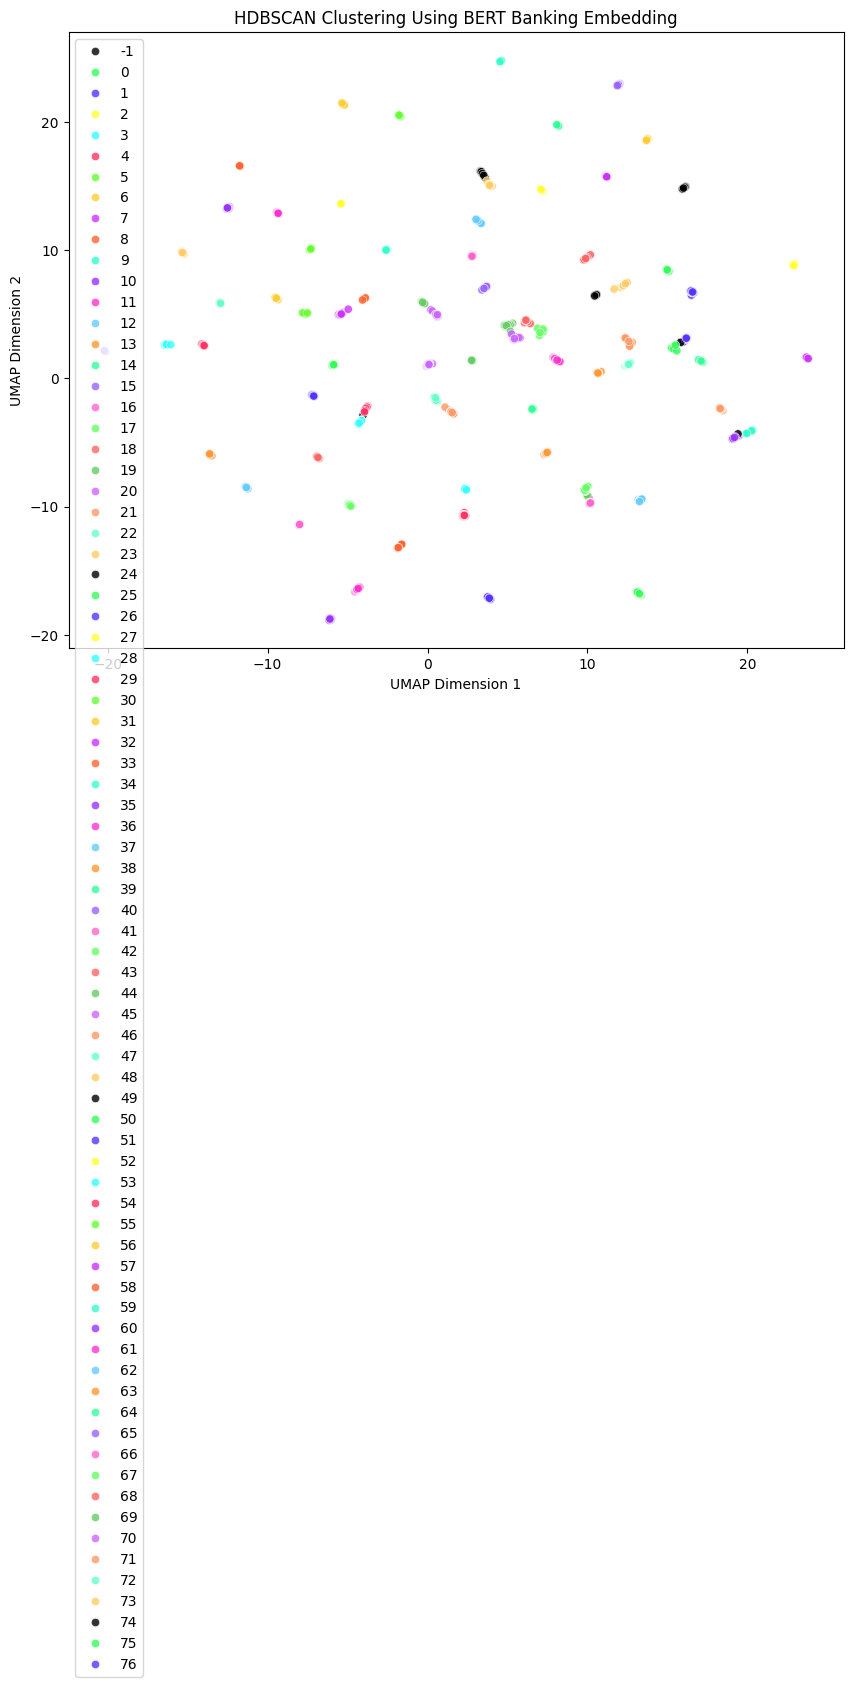

In [47]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]

custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_bert77[:, 0], y=umap_bert77[:, 1], hue=test["topic_BERT77"],
                legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering Using BERT Banking Embedding')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

#### For each cluster, output the unique categories in that cluster, and their respective count:

In [ ]:
cluster_info = {}
for i in np.unique(hdbscan_bert77.labels_):
  rah = test[test["topic"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    if count > 3:
      category_info[index] = count

  cluster_info[i] = category_info

cluster_info

### HDBSCAN on BERT embeddings:

#### Random Search for Parameters:

In [ ]:
%%time
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())

space = {
        "n_neighbors": range(5,15),
        "n_components": range(5,12),
        "min_cluster_size": range(10,25),
        "random_state": 42
    }

random_use = random_search(bert_embeddings, space, 15)

In [ ]:
parametersList2 = [
    [0, 5, 10, 23, 21, 0.00909090909090909],
     [1, 11, 7, 18, 3, 0.003246753246753247],
      [2, 13, 10, 24, 3, 0.003246753246753247],
       [3, 12, 9, 17, 3, 0.002922077922077922],
        [4, 6, 9, 21, 5, 0.010064935064935065],
         [5, 9, 8, 18, 24, 0.015909090909090907],
          [6, 5, 5, 13, 49, 0.05097402597402598],
           [7, 8, 11, 12, 41, 0.03214285714285714],
            [8, 11, 9, 24, 3, 0.0035714285714285713],
             [9, 11, 11, 13, 3, 0.002922077922077922],
              [10, 10, 11, 19, 3, 0.003246753246753247],
               [11, 13, 8, 23, 3, 0.0012987012987012987],
                [12, 8, 9, 24, 5, 0.0042207792207792205],
                 [13, 6, 5, 21, 22, 0.012337662337662338],
                  [14, 10, 5, 19, 3, 0.002922077922077922]
    ]
result_df2 = pd.DataFrame(parametersList2, columns=['run_id', 'n_neighbors', 'n_components','min_cluster_size', 'label_count', 'cost'])
result_df2.sort_values(by='cost')

#### Clustering and Plotting:

In [32]:
# Use the best parameters from the grid search of Bert Banking
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())
umap_bert = umap.UMAP(n_neighbors=35, n_components=2, metric='cosine').fit_transform(bert_embeddings)

In [33]:
hdbscan_bert = HDBSCAN(min_cluster_size=15, min_samples=21, gen_min_span_tree=True,
                       cluster_selection_method='eom')

test["topic_BERT"] = hdbscan_bert.fit_predict(umap_bert)
np.unique(hdbscan_bert.labels_)

array([0, 1])

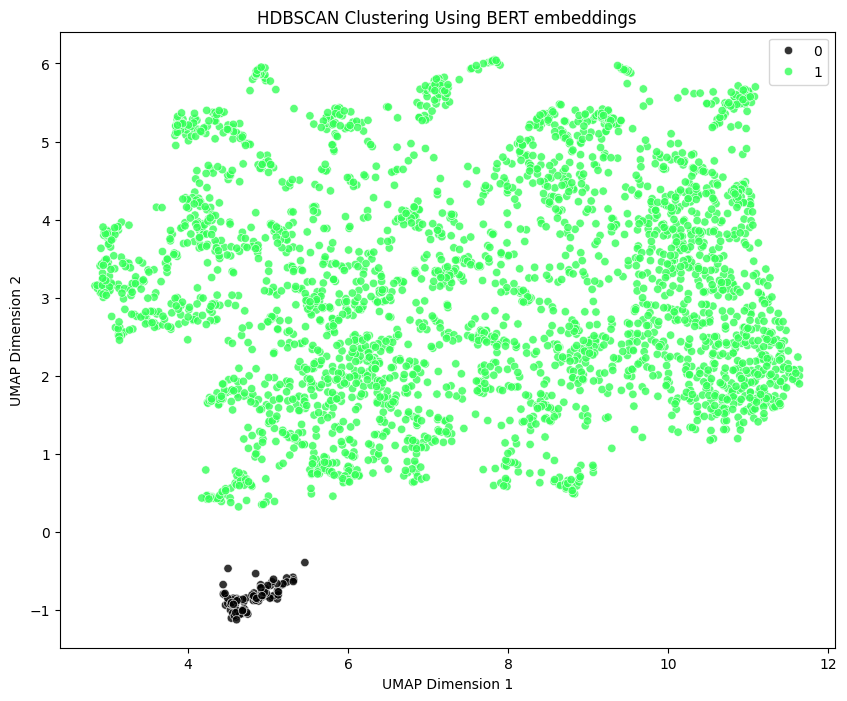

In [38]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]

custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_bert[:, 0], y=umap_bert[:, 1], hue=test["topic_BERT"], legend='full',
                alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering Using BERT embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

#### For each cluster, output the unique categories in that cluster, and their respective count:

In [ ]:
cluster_info = {}
for i in np.unique(hdbscan_bert.labels_):
  rah = test[test["topic_BERT"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    if count > 3:
      category_info[index] = count

  cluster_info[i] = category_info

cluster_info